In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.model_selection import train_test_split
import tensorflow as tf

import gc

In [82]:
from psutil import *
cpu_count()
!lscpu | grep 'Model name'
!df -h / |awk '{print $4}'
! free -h --si |awk '/Mem:/{print $2}'
!nvidia-smi -L
!nvidia-smin 

Model name:                         Intel(R) Xeon(R) CPU @ 2.20GHz
Avail
2.7T
32G
/bin/bash: nvidia-smi: command not found
/bin/bash: nvidia-smin: command not found


In [83]:
n = 3000000 #number of records in file
s = int(0.0002*n )#desired sample size

random.seed(43)
header = pd.read_csv('/kaggle/input/hackaton/Question3_train.csv', nrows=0).columns.tolist()
train = pd.read_csv('/kaggle/input/hackaton/Question3_train.csv', skiprows=sorted(random.sample(range(n),n-s)), header=None, names=header)

train.describe()

,eventID,PID,momentum,theta,phi,X0,X1,X2,X3,X4,...,Z50,Z51,Z52,Z53,Z54,Z55,Z56,Z57,Z58,Z59
count,6.010000e+02,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,...,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.0,601.0
mean,1.512030e+06,262.247920,17.518599,15.516582,2.595417,1321.278307,1321.134984,1320.629664,1320.700641,1319.836309,...,108.617821,76.988226,46.189616,22.989944,15.502445,11.513999,7.740998,3.996987,0.0,0.0
std,8.528531e+05,54.917576,1.408073,0.276102,1.441691,20.585798,20.747924,21.207281,23.766241,26.050451,...,491.972715,415.508629,324.048180,229.236402,189.553994,162.819652,134.082403,97.987333,0.0,0.0
min,5.710000e+02,211.000000,15.001176,15.007519,0.007704,1280.162200,1280.963900,1168.736500,1198.335600,1147.988000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
25%,7.977920e+05,211.000000,16.337864,15.307241,1.295123,1302.948000,1303.323400,1304.477900,1301.355500,1301.646200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
50%,1.441426e+06,211.000000,17.482634,15.520612,2.626455,1321.406900,1322.847500,1321.617100,1318.970800,1318.957400,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
75%,2.263905e+06,321.000000,18.732845,15.744077,3.860161,1338.537800,1338.195900,1337.277100,1339.481100,1339.455300,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
max,2.999999e+06,321.000000,19.983381,15.999728,4.999046,1433.888200,1415.305500,1365.049200,1511.200100,1503.400800,...,2447.338000,2438.251500,2449.002700,2413.920000,2354.655300,2433.204300,2345.358400,2402.189000,0.0,0.0


In [84]:
#pip install --upgrade pip


In [85]:
#pip install tables

In [86]:
df =pd.DataFrame({'eventID':[], 'PID':[], 'momentum':[], 'theta':[], 'phi':[], 'image':[] })
df  = df.astype('object')

length = train.shape[0]
print(length)


for ii in range(0,length):
    event =train.iloc[ii]
    x = [event[f"X{i}"]*2300/event[f"Z{i}"] for i in range(0, 60) if event[f"X{i}"] != 0.0]
    y = [event[f"Y{i}"]*2300/event[f"Z{i}"] for i in range(0, 60) if event[f"Y{i}"] != 0.0]

    PionKaon  = 0 if event["PID"] == 211 else 1
    counts, binsx, binsy = np.histogram2d(x, y, bins=(np.linspace(1000, 1600,65),np.linspace(-500, 500,65)))


    df.loc[ii] = [event["eventID"], PionKaon, event["momentum"], event["theta"], event["phi"], counts]


df.head()

601


,eventID,PID,momentum,theta,phi,image
0,571.0,0,16.494404,15.887424,0.970091,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,6019.0,0,16.181360,15.093530,1.195918,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,14383.0,0,16.870596,15.112328,3.575180,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,16794.0,0,17.078217,15.627325,2.681320,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,18679.0,0,18.994741,15.975708,3.091058,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


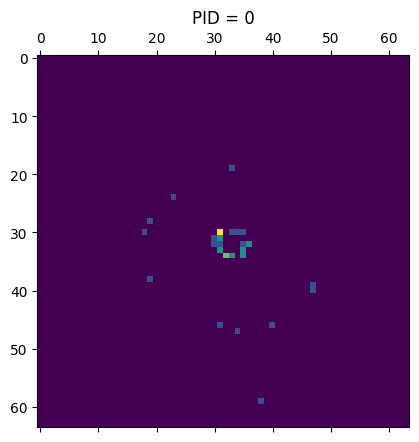

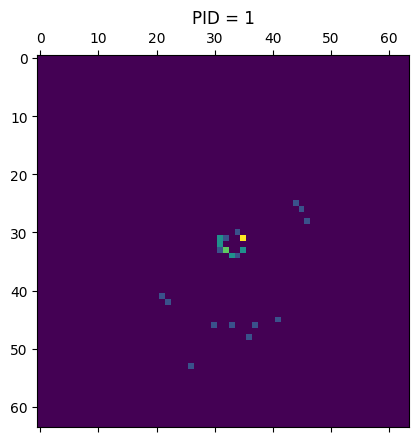

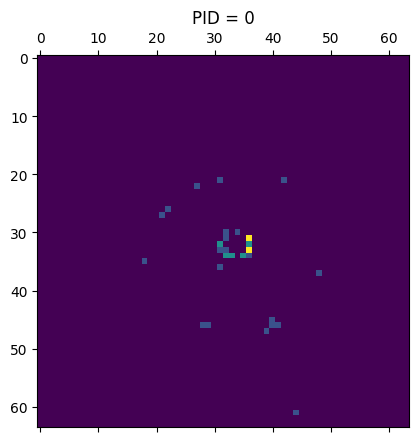

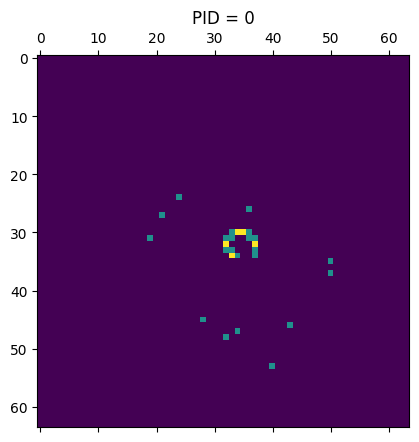

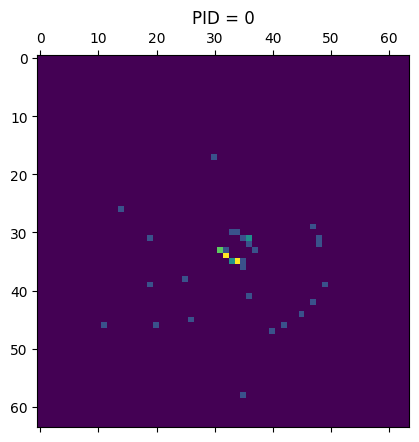

In [87]:
for i in random.sample(range(length),5):
    plt.matshow(df.loc[i,"image"])
    plt.title(f'PID = {df.loc[i,"PID"]}')

# Building CNN

In [88]:
images = np.stack(df['image'].to_numpy()).reshape(length,64,64)
print(images.shape)

labels = np.array(df["PID"]).reshape(length,1)
print(labels.shape)

(601, 64, 64)
(601, 1)


In [89]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=421)

In [100]:
model = tf.keras.Sequential([
    tf.keras.layers.ZeroPadding2D(padding=(3, 3), input_shape=(64, 64, 1)),
    tf.keras.layers.Conv2D(filters = 32,kernel_size =(7,7),strides=(1, 1)),
    #tf.keras.layers.BatchNormalization(axis=3),
    #tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 1, activation='sigmoid')
    ])

model.compile(
  'adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_4 (ZeroPadd  (None, 70, 70, 1)         0         
 ing2D)                                                          
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        1600      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 32769     
                                                                 
Total params: 34369 (134.25 KB)
Trainable params: 3436

In [95]:
#model.fit(X_train, y_train, epochs=3, batch_size=16)

In [97]:
#model.evaluate(X_test, y_test)

In [101]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(16)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(16)
history = model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
34/34 [==============================] - 2s 43ms/step - loss: 0.5100 - accuracy: 0.7870 - val_loss: 0.3160 - val_accuracy: 0.9672
Epoch 2/50
34/34 [==============================] - 1s 42ms/step - loss: 0.1994 - accuracy: 0.9537 - val_loss: 0.1418 - val_accuracy: 0.9672
Epoch 3/50
34/34 [==============================] - 1s 39ms/step - loss: 0.0978 - accuracy: 0.9852 - val_loss: 0.1113 - val_accuracy: 0.9344
Epoch 4/50
34/34 [==============================] - 1s 40ms/step - loss: 0.0578 - accuracy: 0.9907 - val_loss: 0.0903 - val_accuracy: 0.9344
Epoch 5/50
34/34 [==============================] - 1s 40ms/step - loss: 0.0365 - accuracy: 0.9963 - val_loss: 0.0633 - val_accuracy: 1.0000
Epoch 6/50
34/34 [==============================] - 1s 40ms/step - loss: 0.0238 - accuracy: 0.9981 - val_loss: 0.0576 - val_accuracy: 0.9836
Epoch 7/50
34/34 [==============================] - 1s 38ms/step - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.0483 - val_accuracy: 1.0000
Epoch 8/50
34

/tmp/ipykernel_42/2330178472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
/tmp/ipykernel_42/2330178472.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

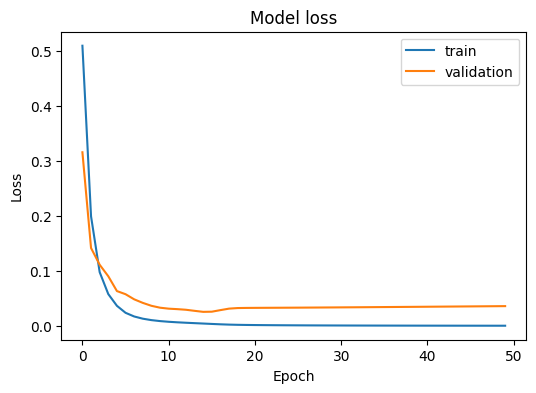

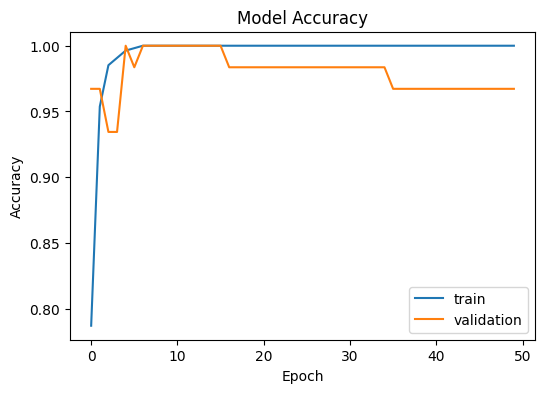

In [102]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on.
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')

In [103]:
import visualkeras
visualkeras.layered_view(model)

ModuleNotFoundError: No module named 'visualkeras'